# 🤒 Epidemic mitigation project - solution notebook

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from IPython.display        import clear_output
from torch                  import Tensor
from gym                    import spaces

from matplotlib.patches     import Patch
from matplotlib.figure      import Figure
from matplotlib.axes        import Axes

from tqdm.notebook          import tqdm
from collections            import namedtuple, deque
from typing                 import List, Dict, Any

"""Environment imports"""
from epidemic_env.env import Env
from epidemic_env.dynamics import ModelDynamics # why is this needed?
from epidemic_env.visualize import Visualize


"""Deep learnining module imports"""
from deep_q_learning.agent import Agent
from deep_q_learning.trainer import AbstractTrainer

# """Should be written by the student"""
# from deep_q_learning.agent import DQNAgent, FactoredDQNAgent, NaiveAgent
# from deep_q_learning.trainer import Trainer
# import deep_q_learning.model as models

## 1. Introduction

### Question 1.a) study the behavior of the model when the epidemics are unmitigated

First we define the plotting function :

In [2]:
%matplotlib inline
def plot_episode(total, cities, actions=None):
    fig = plt.figure(figsize=(14,7))
    if actions:
        ax_left = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=7)
        ax_bleft = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    else:
        ax_left = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=9)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1,sharex=ax_right[0]) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_left.plot(y) for y in total.values()]
    ax_left.legend(total.keys())
    ax_left.set_title('Full state')
    ax_left.set_ylabel('number of people in each state')
    ax_left.set_xlabel('time (in weeks)')
    
    if actions:
        ax_bleft.matshow(np.array([v for v in actions.values()]).astype(np.uint8))
        ax_bleft.set_yticks([0,1,2,3])
        ax_bleft.set_yticklabels(list(actions.keys()))
        ax_bleft.set_xlabel('weeks')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_title(c) for c, ax in ax_right.items()]
    [ax.legend(['infected','dead']) for ax in ax_right.values()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')

    fig.tight_layout()
    plt.show()


Then we play through a full epidemic episode as follows:

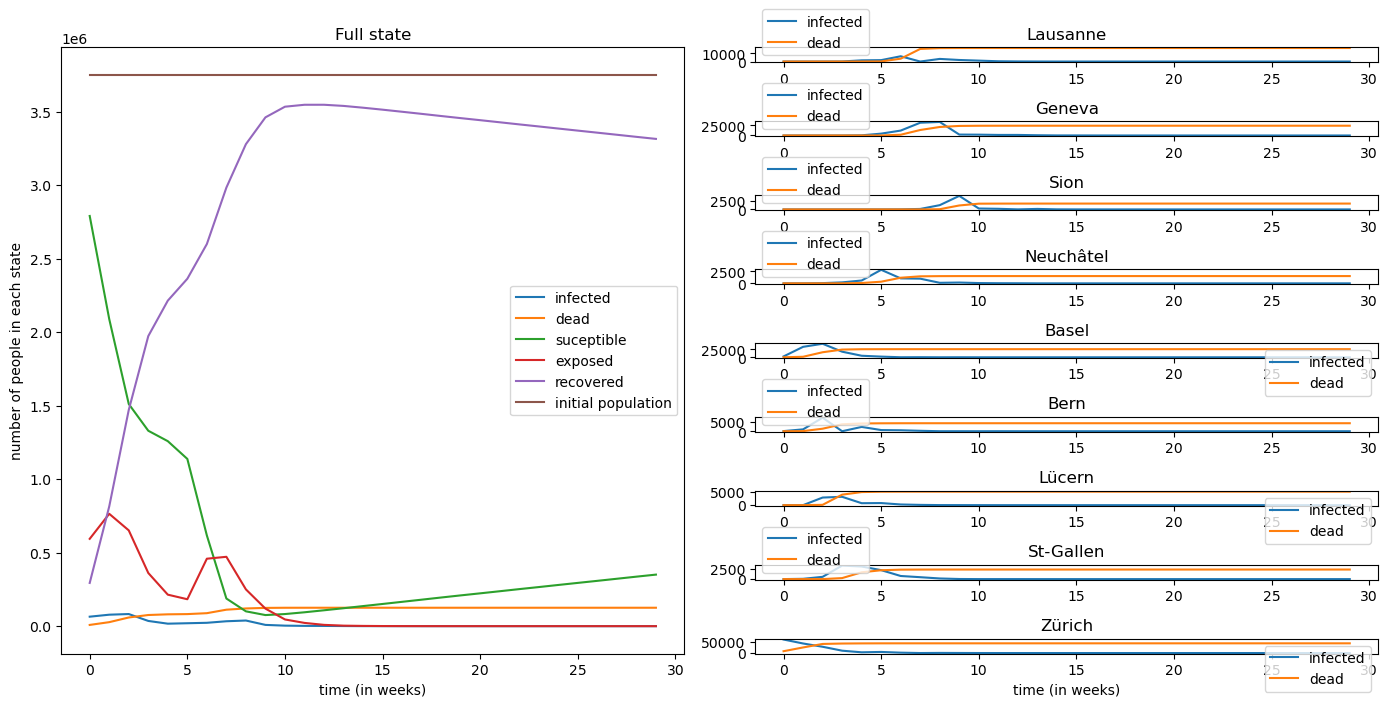

In [7]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment"""
env = Env(dyn)

action = action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
while not finished:
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([l['parameters']['total'][p] for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([l['parameters']['cities'][c][p] for l in log]) for p in dyn.parameters} for c in dyn.cities}
plot_episode(total, cities)

## 2. Professor Russo's Policy

### Question 2.a) implement Pr. Russo's Policy

In [8]:
class Russo(Agent):
    def __init__(self,  env:Env,
                 threshold:int=20000,
                 confine_time:int=4,):
        """Naive Agent implementation. Gives a baseline to compare reinforcement learning agent_dec_eps_dec_epss against. 
        The naive policy is the following:
        ```pseudocode
        If number of infected people > THRESHOLD
            confine the entire country for CONFINEMENT_TIME weeks
        ```

        Args:
            env (_type_): the simulation environment.
            threshold (int, optional): The infected threshold, upon which confiment must start. Defaults to 20000.
            confine_time (int, optional): The confinement time. Defaults to 4.
        """

        self.env = env
        self.threshold = threshold
        self.confine_time = confine_time
        self.timer = 0
    def load_model(self, savepath):
        pass

    def save_model(self, savepath):
        pass

    def optimize_model(self):
        #This is agent is born stupid and stays stupid
        return 0
    
    def reset(self,):
        self.timer = 0

    def act(self, obs):
        if self.timer > 0:
            self.timer -=1
            return 1, 0
        if obs > self.threshold:
            self.timer = self.confine_time
            return 1, 0
        return 0,0

In [9]:
def russo_act_pre(a, dyn:ModelDynamics):
    return {
        'confinement': a==1,
        'isolation': False,
        'hospital': False,
        'vaccinate': False,
    }

def russo_obs_pre(obs_dict:Dict[str,Any], dyn:ModelDynamics):
    return obs_dict['total']['infected'][-1]

#### Running and plotting a single episode

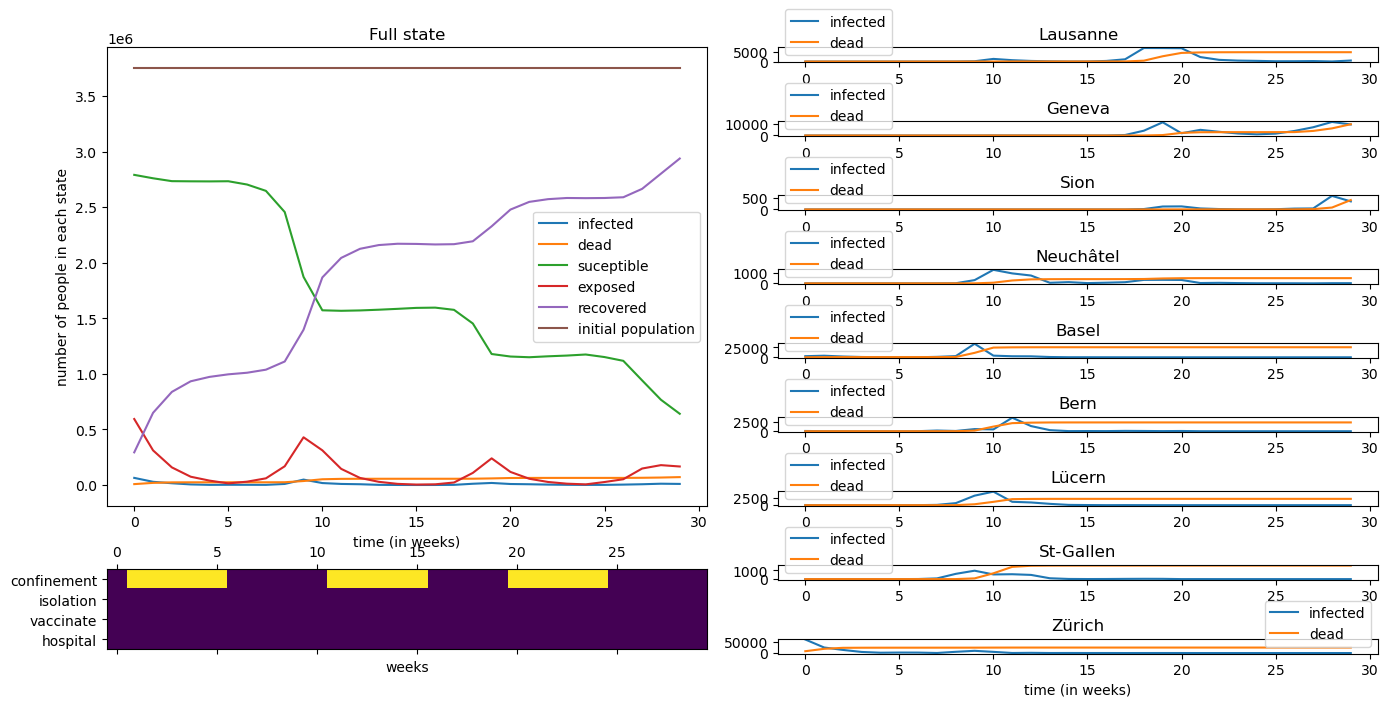

In [27]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_preprocessor=russo_act_pre,
            observation_preprocessor=russo_obs_pre)
agent = Russo(env) # defined above

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
while not finished:
    action, _ = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse th£e logs """
total = {p:np.array([l['parameters']['total'][p] for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([l['parameters']['cities'][c][p] for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l['action'][a] for l in log]) for a in log[0]['action'].keys()}
(total,cities,actions)

plot_episode(total,cities,actions)

### Question 2.b) evaluate Pr. Russo's Policy

Defining the generic evaluation procedure

In [11]:
def evaluate(env, agent, eval_iterations = 50, pbar=True):
    logs = []; rewards = []
    agent.epsilon = 0
    _range = range(eval_iterations)
    if pbar: _range = tqdm(_range,desc='Eval iteration')
    for eval_iter in _range:
        """ Run an episode """
        finished = False
        log = []; R_cum = 0;
        obs, info = env.reset(seed=eval_iter)
        agent.reset()
        while not finished:
            action, est_Q = agent.act(obs)
            obs, R, finished, info = env.step(action)
            log.append(info); R_cum += R
            if finished:
                break
            
        """ Parse the logs as they are generated """
        log = {
            'total': {p:np.array([l['parameters']['total'][p] for l in log]) for p in dyn.parameters},
            'cities': {c:{p:np.array([l['parameters']['cities'][c][p] for l in log]) for p in dyn.parameters} for c in dyn.cities},
            'actions': {a:np.array([l['action'][a] for l in log]) for a in log[0]['action'].keys()}
        } 
        logs.append(log)
        rewards.append(R_cum)
    return logs, np.array([float(r) for r in rewards])

Running the evaluation

In [17]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_preprocessor=russo_act_pre,
            observation_preprocessor=russo_obs_pre)
agent = Russo(env) # defined above

""" Run the evaluation """
logs, rewards = evaluate(env,agent,50)

""" Parse the data """
deaths = np.array([l['total']['dead'][-1] for l in logs])
conf_days = np.array([np.sum(np.array(l['actions']['confinement']).astype(np.uint8))*7 for l in logs])

Eval iteration:   0%|          | 0/50 [00:00<?, ?it/s]

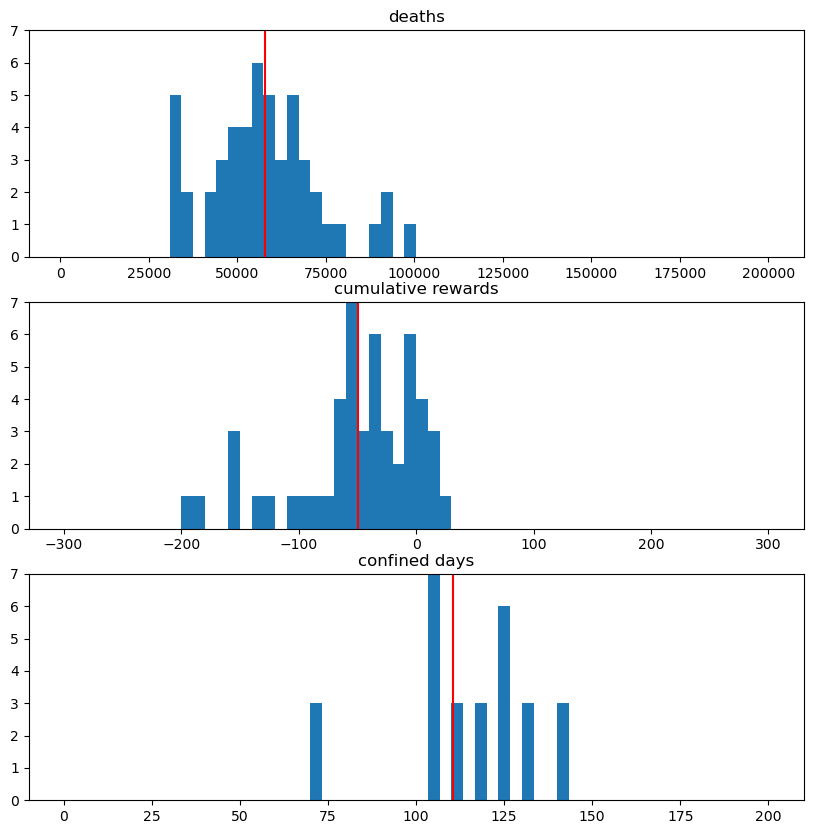

Average death number: 57749.34
Average number of confined days: 110.46
Average cumulative reward: -49.51062625169754


In [18]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
def hist_avg(ax, data,title,x_range,ymax):
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths',(1000,200000),7)
hist_avg(ax[1], rewards,'cumulative rewards',(-300,300),7)
hist_avg(ax[2], conf_days,'confined days',(0,200),7)
plt.show()
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')

## 3. A Deep-Q-learning approach

### Question 3.a) implementing adaptive Pr. Russo's

#### Action / Observation Preprocessors

In [19]:
SCALE = 100 

def binary_act_pre(a:torch.Tensor, dyn:ModelDynamics):
    conf = (dyn.c_confined['Lausanne'] != 1)
    isol = (dyn.c_isolated['Lausanne'] != 1)
    vacc = (dyn.vaccinate['Lausanne'] != 0)
    hosp = (dyn.extra_hospital_beds['Lausanne'] != 1)
    conf = (a == 1)
    
    return {
        'confinement': conf,
        'isolation': isol,
        'hospital': hosp,
        'vaccinate': vacc,
    }
    
def naive_obs_pre(obs_dict:Dict[str,Any], dyn:ModelDynamics):
    infected = SCALE * \
        np.array([np.array(obs_dict['city']['infected'][c]) /
                    obs_dict['pop'][c] for c in dyn.cities])
    dead = SCALE * \
        np.array([np.array(obs_dict['city']['dead'][c])/obs_dict['pop'][c]
                    for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

#### Deep Q-learning agent class

In [20]:
"""Simple DQN implementaiton 
(stolen from : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#replay-memory)
"""

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    """ Useful replay memory class """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQNAgent(Agent):
    """ Deep-Q-Learning agent implementation """
    def __init__(self,  env:Env,
                 model:torch.nn,
                 criterion=nn.HuberLoss(),
                 lr:float=5e-4,
                 epsilon:float=0.5,
                 gamma:float=0.99,
                 buffer_size:int=10000,
                 batch_size:int=64)->None:

        self.env = env
        model_params = {
            'in_dim': len(env.observation_space.sample().flatten()),
            'out_dim': env.action_space.n,
        }
        self.model = model(**model_params)
        self.targetModel = model(**model_params)

        self.criterion = criterion

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.memory = ReplayMemory(buffer_size)
        self.batch_size = batch_size

        self.epsilon = epsilon
        self.gamma = gamma
        self.lr = lr

    def load_model(self, savepath):
        torch.save(self.model.state_dict(), savepath)
        self.model.load_state_dict(torch.load(savepath))

    def save_model(self, savepath):
        torch.save(self.model.state_dict(), savepath)

    def optimize_model(self): 
        """ Implements a training step """
        if len(self.memory) < self.batch_size:
            return np.double(0) # Do nothing if not enough samples

        """ Sampling memory and batch construction"""
        transitions = self.memory.sample(self.batch_size)
        # Convert Batch(Transitions) -> Transition(Batch)
        batch = Transition(*zip(*transitions))
        action_batch = torch.tensor([e for e in batch.action])
        state_batch = torch.cat(batch.state, 0)
        next_states_batch = torch.cat(batch.next_state, 0)
        reward_batch = torch.cat(batch.reward)

        """ Loss computation """
        state_action_values = self.model( # Compute Q(S, a) with the Q-value network
            state_batch).gather(1, action_batch.unsqueeze(1))
        
        next_state_values = self.targetModel(next_states_batch).max(1)[
            0].detach().unsqueeze(1) # Compute max_ap Q(Sp) with the stable target network
        expected_state_action_values = ( # Compute the expected Q values
            next_state_values * self.gamma) + reward_batch


        loss = self.criterion(state_action_values,  # Compute the loss
                              expected_state_action_values)

        """ One gradient descent step """
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return np.double(loss)

    def act(self, obs:np.ndarray):
        """ Actions from observations """
        x = torch.Tensor(obs)
        Q_est = self.model(x)
        
        if random.random() > self.epsilon:
            with torch.no_grad():
                return np.argmax(Q_est), float(Q_est.detach().max())
        else:
            act = self.env.action_space.sample()
            return act, float(Q_est.detach()[0][act])
    
    def reset(self,):
        pass # Not stateful

#### Building the neural network

In [21]:
class DQN(nn.Module):
    """Fully connected Q-Value estimator network."""
    def __init__(self, in_dim:int=126, out_dim:int=16)-> nn.Module:
        super().__init__()
        
        lin_layers = []
        lin1 = nn.Linear(in_features=in_dim, out_features=64)
        relu1 = nn.ReLU()
        lin_layers += [lin1, relu1]
        lin2 = nn.Linear(in_features=64, out_features=32)
        relu2 = nn.ReLU()
        lin_layers += [lin2, relu2]
        lin3 = nn.Linear(in_features=32, out_features=16)
        relu3 = nn.ReLU()
        lin_layers += [lin3, relu3]
        lin4 = nn.Linear(in_features=16, out_features=out_dim)
        lin_layers += [lin4]

        self.fcn = nn.Sequential(*lin_layers)

    def forward(self, x:Tensor) -> Tensor:
        x = self.fcn(x.view(x.size(0), -1))
        return x

#### Training the agent

In [22]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = 1e-3,
                    epsilon = 0.6,
                    gamma = 0.9,
                    buffer_size=10000,
                    batch_size=1024)

RUN_NAME = 'deep_q_learning'
RESULTS_FOLDER = 'results/'
MODEL_FOLDER = 'models/'
NUM_EPISODES = 300
EVAL_RATE = 50
EVAL_SAMPLES = 20
TARGET_UPDATE_RATE = 10
EPSILON = 0.7
torch.manual_seed(0)

In [23]:
max_reward = -1e10
rlog_training = []
rlog_eval = []
x_eval = []
for episode in tqdm(range(NUM_EPISODES)):
    if episode % TARGET_UPDATE_RATE == 0:
        agent.targetModel.load_state_dict(agent.model.state_dict())

    finished = False
    obs, info = env.reset()
    agent.reset()
    agent.epsilon = EPSILON
    
    R_cum = 0
    while not finished:
        action, est_Q = agent.act(obs)
        obs_next, R, finished, info = env.step(action)
        agent.memory.push(obs, action, obs_next, R)
        loss = agent.optimize_model()
        obs = obs_next; R_cum += R
        if finished:
            break
    rlog_training.append(R_cum)
    if episode % EVAL_RATE == 0 or (episode == NUM_EPISODES-1):
        agent.epsilon = 0 # evaluation runs are performed with epsilon = 0
        _, rewards = evaluate(env, agent, eval_iterations = EVAL_SAMPLES,pbar=False)
        R_eval = np.mean(rewards)
        rlog_eval.append(R_eval); x_eval.append(episode)
        print( f"Evaluated cumulative reward R={R_eval}.")
        
        if R_eval > max_reward:
            max_reward = R_eval; print( f"    New maximum reward, saving weights!")
            torch.save(agent.model, MODEL_FOLDER + RUN_NAME + '.pkl')
            
RESULTS_FOLDER = 'results/'
training_curves = {
    'run_name': 'adaptive russo',
    'x_eval': x_eval,
    'rlog_eval': rlog_eval,
    'rlog_training': rlog_training,
}
with open(RESULTS_FOLDER + RUN_NAME + '.pkl', 'wb') as file:
    pickle.dump(training_curves,file)

  0%|          | 0/300 [00:00<?, ?it/s]

Evaluated cumulative reward R=-145.16949558258057.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-8.402464401721954.
    New maximum reward, saving weights!
Evaluated cumulative reward R=8.023117470741273.
    New maximum reward, saving weights!
Evaluated cumulative reward R=4.777322053909302.
Evaluated cumulative reward R=-5.318073356151581.
Evaluated cumulative reward R=-5.3654032945632935.
Evaluated cumulative reward R=7.629780602455139.


#### Plotting the training curve

/Users/renard/miniconda3/envs/DeepLearning3.9/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/renard/miniconda3/envs/DeepLearning3.9/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


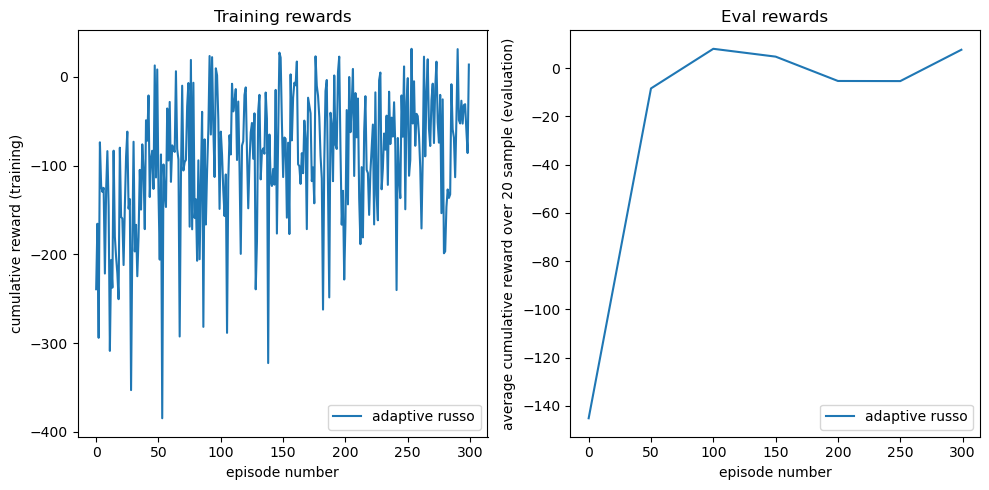

In [24]:
def plot_training_curves(numerical_results):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    for nr in numerical_results:
        ax[0].plot(nr['rlog_training'])
        ax[0].set_title('Training rewards')
        ax[0].set_ylabel('cumulative reward (training)')
        ax[0].set_xlabel('episode number')
        ax[1].plot(nr['x_eval'], nr['rlog_eval'])
        ax[1].set_ylabel('average cumulative reward over 20 sample (evaluation)')
        ax[1].set_xlabel('episode number')
        ax[1].set_title('Eval rewards')
    ax[0].legend([nr['run_name'] for nr in numerical_results])
    ax[1].legend([nr['run_name'] for nr in numerical_results])
    fig.tight_layout()

with open(RESULTS_FOLDER + 'deep_q_learning.pkl', 'rb') as file:
    training_curves =  pickle.load(file)
plot_training_curves([training_curves])

#### Running and plotting a single episode

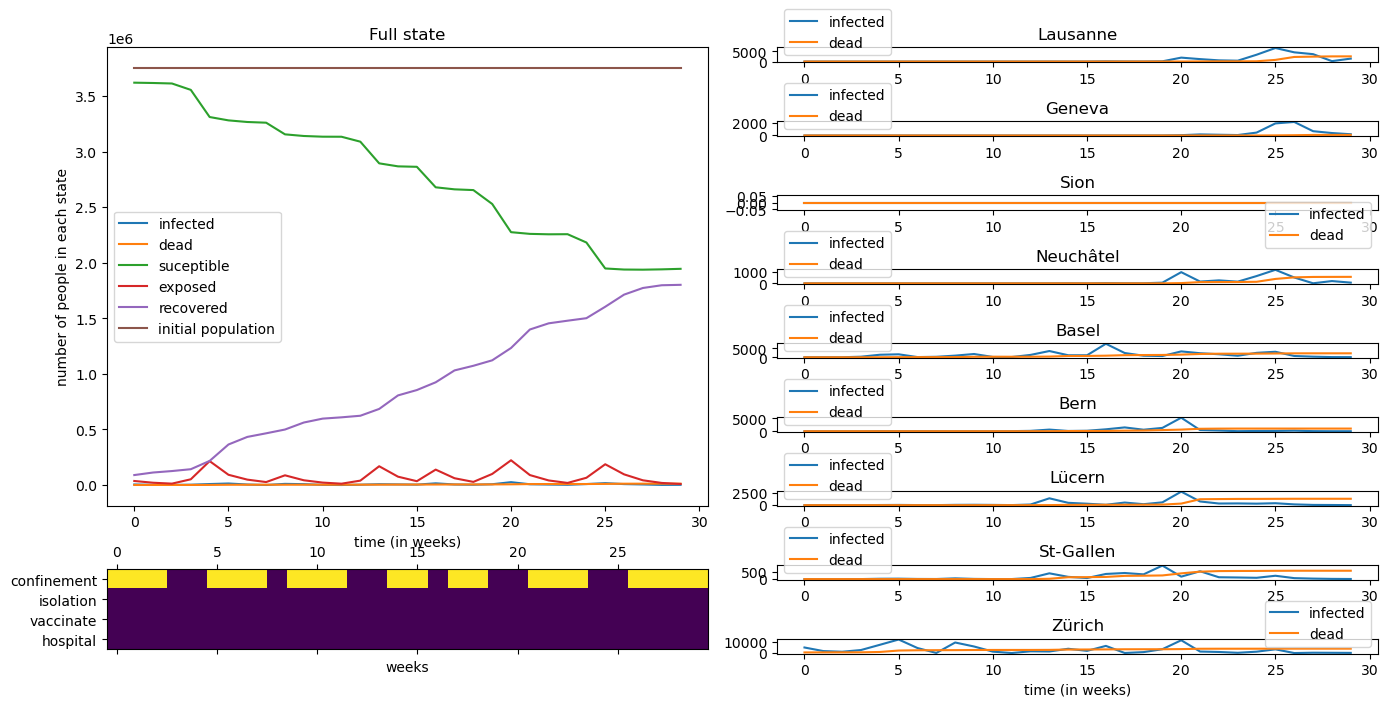

In [37]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = 1e-3,
                    epsilon = 0.6,
                    gamma = 0.9,
                    buffer_size=10000,
                    batch_size=1024)
agent.model = torch.load('models/deep_q_learning.pkl')

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action, _ = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([l['parameters']['total'][p] for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([l['parameters']['cities'][c][p] for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l['action'][a] for l in log]) for a in log[0]['action'].keys()}
(total,cities,actions)

plot_episode(total,cities,actions)

## Question 3.b) Decreasing exploration

In [39]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent_dec_eps = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = 1e-3,
                    epsilon = 0.6,
                    gamma = 0.9,
                    buffer_size=10000,
                    batch_size=1024)

RUN_NAME = 'deep_q_learning_dec_epsilon'
MODEL_FOLDER = 'models/'
RESULTS_FOLDER = 'results/'
NUM_EPISODES = 300
EVAL_RATE = 50
EVAL_SAMPLES = 20
TARGET_UPDATE_RATE = 5
EPSILON_0 = 0.7
EPSILON_MIN = 0.2
T_MAX = 300
torch.manual_seed(0)

In [40]:
max_reward = -1e10
rlog_training = []
rlog_eval = []
x_eval = []
for episode in tqdm(range(NUM_EPISODES)):
    if episode % TARGET_UPDATE_RATE == 0:
        agent_dec_eps.targetModel.load_state_dict(agent_dec_eps.model.state_dict())

    finished = False
    obs, info = env.reset()
    agent_dec_eps.reset()
    agent_dec_eps.epsilon = max([EPSILON_0*(T_MAX-episode)/T_MAX,
                         EPSILON_MIN])
    
    R_cum = 0
    while not finished:
        action, est_Q = agent_dec_eps.act(obs)
        obs_next, R, finished, info = env.step(action)
        agent_dec_eps.memory.push(obs, action, obs_next, R)
        loss = agent_dec_eps.optimize_model()
        obs = obs_next; R_cum += R
        if finished:
            break
    rlog_training.append(R_cum)
    if episode % EVAL_RATE == 0 or (episode == NUM_EPISODES-1):
        agent_dec_eps.epsilon = 0 # evaluation runs are performed with epsilon = 0
        _, rewards = evaluate(env, agent_dec_eps, eval_iterations = EVAL_SAMPLES,pbar=False)
        R_eval = np.mean(rewards)
        rlog_eval.append(R_eval); x_eval.append(episode)
        print( f"Evaluated cumulative reward R={R_eval}.")
        
        if R_eval > max_reward:
            max_reward = R_eval; print( f"    New maximum reward, saving weights!")
            torch.save(agent_dec_eps.model, MODEL_FOLDER + RUN_NAME + '.pkl')

RESULTS_FOLDER = 'results/'
training_curves = {
    'run_name': 'decreasing epsilon',
    'x_eval': x_eval,
    'rlog_eval': rlog_eval,
    'rlog_training': rlog_training,
}
with open(RESULTS_FOLDER + RUN_NAME + '.pkl', 'wb') as file:
    pickle.dump(training_curves,file)

  0%|          | 0/300 [00:00<?, ?it/s]

Evaluated cumulative reward R=23.755456161499023.
    New maximum reward, saving weights!


/Users/renard/miniconda3/envs/DeepLearning3.9/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/renard/miniconda3/envs/DeepLearning3.9/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


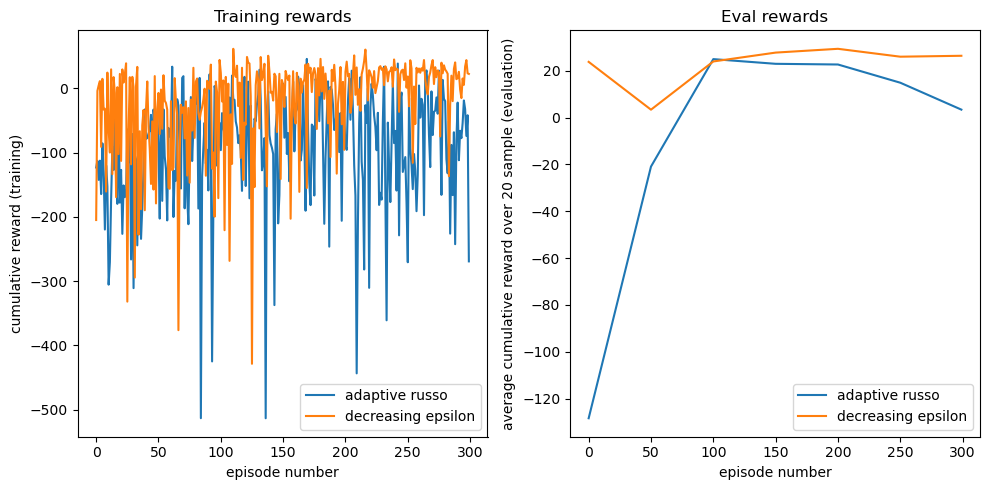

In [ ]:
with open(RESULTS_FOLDER + 'deep_q_learning.pkl', 'rb') as file:
    training_curves_ad_russo =  pickle.load(file)
with open(RESULTS_FOLDER + 'deep_q_learning_dec_epsilon.pkl', 'rb') as file:
    training_curves_dec_eps =  pickle.load(file)
plot_training_curves([training_curves_ad_russo,training_curves_dec_eps])

## Question 3.c) Evaluation


In [ ]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = 1e-3,
                    epsilon = 0.6,
                    gamma = 0.9,
                    buffer_size=10000,
                    batch_size=1024)
agent.model = torch.load('models/deep_q_learning_dec_epsilon.pkl')


""" Run the evaluation """
logs, rewards = evaluate(env,agent)

""" Parse the data """
deaths = np.array([l['total']['dead'][-1] for l in logs])
conf_days = np.array([np.sum(np.array(l['actions']['confinement']).astype(np.uint8))*7 for l in logs])

Eval iteration:   0%|          | 0/50 [00:00<?, ?it/s]

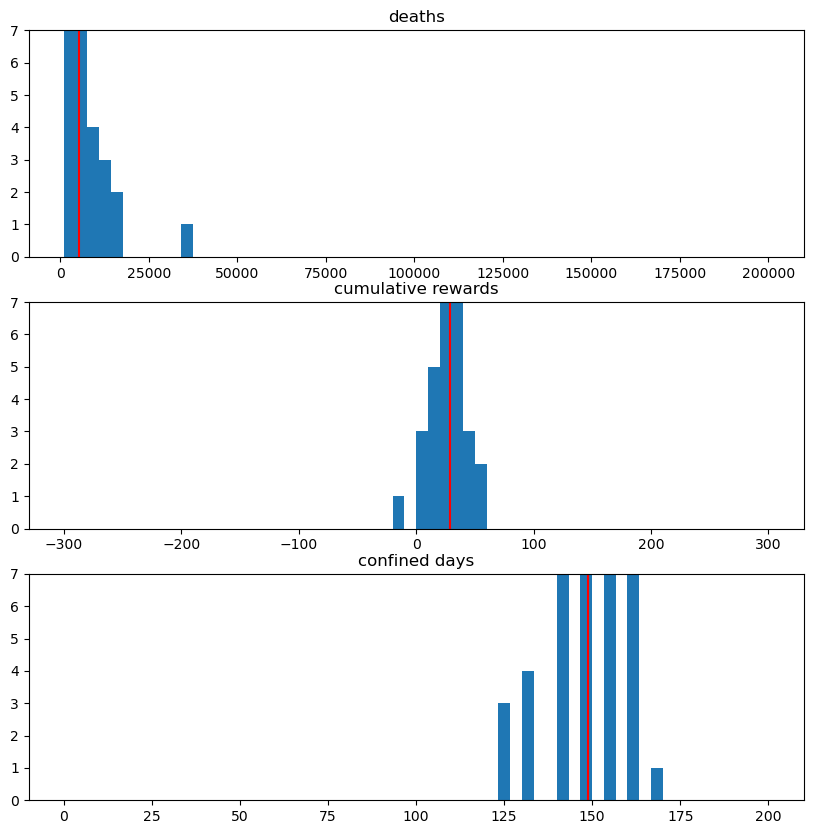

Average death number: 5297.24
Average cumulative reward: 28.91957034111023


In [ ]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
def hist_avg(ax, data,title,x_range,ymax):
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths',(1000,200000),7)
hist_avg(ax[1], rewards,'cumulative rewards',(-300,300),7)
hist_avg(ax[2], conf_days,'confined days',(0,200),7)
plt.show()
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')

# Dealing with a more complex action space

## Question 4.1.b) Toggle-action-space multi-action policy training

### Action / Observation Preprocessors

In [ ]:
SCALE = 100 
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

def toggle_act_pre(a:torch.Tensor, dyn:ModelDynamics):
    conf = (dyn.c_confined['Lausanne'] != 1)
    isol = (dyn.c_isolated['Lausanne'] != 1)
    vacc = (dyn.vaccinate['Lausanne'] != 0)
    hosp = (dyn.extra_hospital_beds['Lausanne'] != 1)
    
    if a == ACTION_CONFINE:
        conf = not conf
    elif a == ACTION_ISOLATE:
        isol = not isol
    elif a == ACTION_VACCINATE:
        vacc = not vacc
    elif a == ACTION_HOSPITAL:
        hosp = not hosp
    
    return {
        'confinement': conf,
        'isolation': isol,
        'hospital': hosp,
        'vaccinate': vacc,
    }
    
def toggle_obs_pre(obs_dict:Dict[str,Any], dyn:ModelDynamics):
    infected = SCALE * \
        np.array([np.array(obs_dict['city']['infected'][c]) /
                    obs_dict['pop'][c] for c in dyn.cities])
    dead = SCALE * \
        np.array([np.array(obs_dict['city']['dead'][c])/obs_dict['pop'][c]
                    for c in dyn.cities])
    confined = np.ones_like(
        dead)*int((dyn.c_confined['Lausanne'] != 1))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

### Training the agent

In [ ]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env_toggle = Env(  dyn,
            action_space=spaces.Discrete(5),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(3, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = DQNAgent(    env = env,
                            model = DQN,
                            criterion = nn.HuberLoss(),
                            lr = 1e-3,
                            epsilon = 0.6,
                            gamma = 0.9,
                            buffer_size=10000,
                            batch_size=1024)

RUN_NAME = 'deep_q_learning_toggle'
MODEL_FOLDER = 'models/'
RESULTS_FOLDER = 'results/'
NUM_EPISODES = 300
EVAL_RATE = 50
EVAL_SAMPLES = 20
TARGET_UPDATE_RATE = 5
EPSILON_0 = 0.7
EPSILON_MIN = 0.2
T_MAX = 300

In [ ]:
max_reward = -1e10
rlog_training = []
rlog_eval = []
x_eval = []
for episode in tqdm(range(NUM_EPISODES)):
    if episode % TARGET_UPDATE_RATE == 0:
        agent.targetModel.load_state_dict(agent.model.state_dict())

    finished = False
    obs, info = env.reset()
    agent.reset()
    agent.epsilon = max([EPSILON_0*(T_MAX-episode)/T_MAX,
                         EPSILON_MIN])
    
    R_cum = 0
    while not finished:
        action, est_Q = agent.act(obs)
        obs_next, R, finished, info = env.step(action)
        agent.memory.push(obs, action, obs_next, R)
        loss = agent.optimize_model()
        obs = obs_next; R_cum += R
        if finished:
            break
    rlog_training.append(R_cum)
    if episode % EVAL_RATE == 0 or (episode == NUM_EPISODES-1):
        agent.epsilon = 0 # evaluation runs are performed with epsilon = 0
        _, rewards = evaluate(env, agent, eval_iterations = EVAL_SAMPLES,pbar=False)
        R_eval = np.mean(rewards)
        rlog_eval.append(R_eval); x_eval.append(episode)
        print( f"Evaluated cumulative reward R={R_eval}.")
        
        if R_eval > max_reward:
            max_reward = R_eval; print( f"    New maximum reward, saving weights!")
            torch.save(agent.model, MODEL_FOLDER + RUN_NAME + '.pkl')
            
RESULTS_FOLDER = 'results/'
training_curves = {
    'run_name': 'toggled action space',
    'x_eval': x_eval,
    'rlog_eval': rlog_eval,
    'rlog_training': rlog_training,
}
with open(RESULTS_FOLDER + RUN_NAME + '.pkl', 'wb') as file:
    pickle.dump(training_curves,file)

  0%|          | 0/300 [00:00<?, ?it/s]

Evaluated cumulative reward R=-108.85093612670899.
    New maximum reward, saving weights!
Evaluated cumulative reward R=4.269451451301575.
    New maximum reward, saving weights!
Evaluated cumulative reward R=13.860301929712296.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-1.3101661682128907.
Evaluated cumulative reward R=23.02216305732727.
    New maximum reward, saving weights!
Evaluated cumulative reward R=19.6968945145607.
Evaluated cumulative reward R=32.16852091550827.
    New maximum reward, saving weights!


/Users/renard/miniconda3/envs/DeepLearning3.9/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/renard/miniconda3/envs/DeepLearning3.9/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


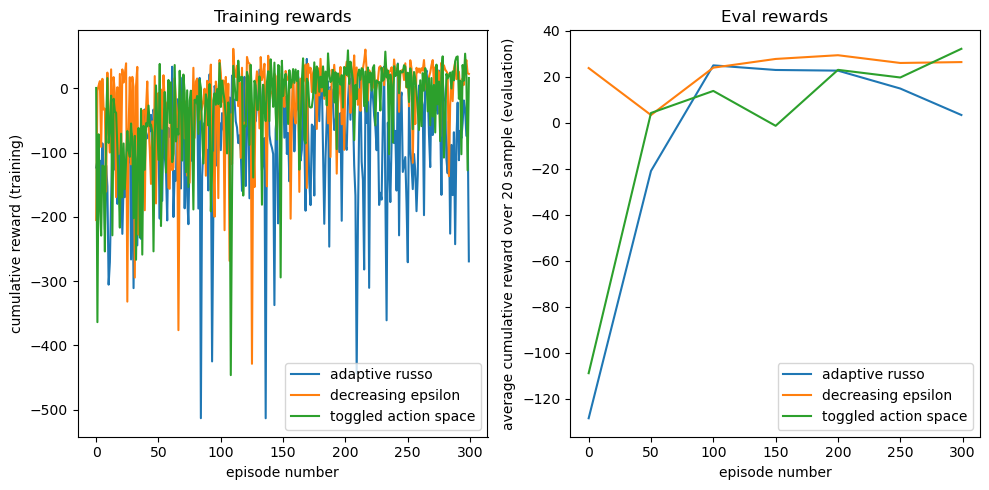

In [ ]:
with open(RESULTS_FOLDER + 'deep_q_learning.pkl', 'rb') as file:
    training_curves_ad_russo =  pickle.load(file)
with open(RESULTS_FOLDER + 'deep_q_learning_dec_epsilon.pkl', 'rb') as file:
    training_curves_dec_eps =  pickle.load(file)
with open(RESULTS_FOLDER + 'deep_q_learning_toggle.pkl', 'rb') as file:
    training_curves_toggle =  pickle.load(file)
    
plot_training_curves([training_curves_ad_russo,training_curves_dec_eps, training_curves_toggle])

## Question 4.1.c) Evaluation

In [ ]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = 1e-3,
                    epsilon = 0.6,
                    gamma = 0.9,
                    buffer_size=10000,
                    batch_size=1024)
agent.model = torch.load('models/deep_q_learning_toggle.pkl')


""" Run the evaluation """
logs, rewards = evaluate(env,agent)

""" Parse the data """
deaths = np.array([l['total']['dead'][-1] for l in logs])
conf_days = np.array([np.sum(np.array(l['actions']['confinement']).astype(np.uint8))*7 for l in logs])

Eval iteration:   0%|          | 0/50 [00:00<?, ?it/s]

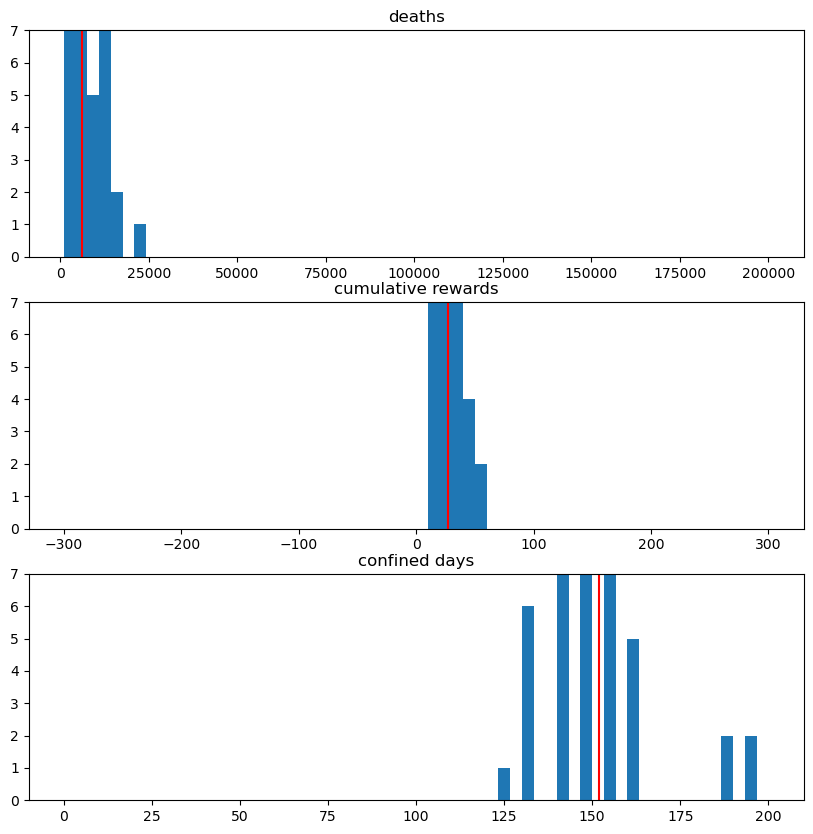

Average death number: 6189.18
Average cumulative reward: 27.379658203125


In [ ]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
def hist_avg(ax, data,title,x_range,ymax):
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths',(1000,200000),7)
hist_avg(ax[1], rewards,'cumulative rewards',(-300,300),7)
hist_avg(ax[2], conf_days,'confined days',(0,200),7)
plt.show()
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')

## Question 4.1.d) Low gamma and vaccination

## Question 4.2.a) multi-action factorized Q-values policy training

## Question 4.2.b) multi-action factorized Q-values policy evaluation

## Question 4.3.a) Result Analysis